In [177]:
from transformers import AutoTokenizer, RobertaModel, AutoModel, RobertaTokenizer
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
class Roberta_Model(nn.Module):
    def __init__(self):
        super(Roberta_Model, self).__init__()
        self.bert = RobertaModel.from_pretrained("FacebookAI/roberta-base")
        self.fc = nn.Linear(768, 4)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        x = self.bert(input_ids, attention_mask)
        x = x['pooler_output']
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

In [31]:
model = Roberta_Model()

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
tokenizer = RobertaTokenizer.from_pretrained("FacebookAI/roberta-base")

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [34]:
# load the model and map_location to device
model.load_state_dict(torch.load('/content/drive/MyDrive/NLP PROJECT/Models/mbti_roberta.pth', map_location=device))

<All keys matched successfully>

In [42]:
def predict(model, tokenizer, df):
    model.eval()
    predictions = []
    with torch.no_grad():
        for i in range(len(df)):
            text = df.iloc[i]['line']
            encoding = tokenizer(
                text,
                return_tensors='pt',
                max_length=256,
                padding='max_length',
                truncation=True
            )
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask)
            outputs = torch.round(outputs)
            predictions.append(torch.tensor(outputs.cpu().numpy(), dtype = int))
        return predictions


def convert_binary_to_personality(binary):
    I = 'I' if (binary[0][0] == (1)) else 'E'
    N = 'N' if (binary[0][1] == (1)) else 'S'
    F = 'F' if (binary[0][2] == (1)) else 'T'
    J = 'J' if (binary[0][3] == (1)) else 'P'
    return I + N + F + J


## IRON MAN (2008)

In [35]:
df_ironman = pd.read_csv('/content/drive/MyDrive/NLP PROJECT/script_csv/iron_man.csv')
df_ironman.head()

,character,line,gender
0,TONY STARK,"Oh, I get it. You guys aren’t allowed to talk...",MALE
1,JIMMY,No. We’re allowed to talk.,MALE
2,TONY STARK,Oh. I see. So it’s personal.,MALE
3,RAMIREZ,I think they’re intimidated.,MALE
4,TONY STARK,"Good God, you’re a woman.",MALE


In [45]:
imp_chars = "PEPPER POTTS- PHIL COULSON- TONY STARK- OBADIAH- CHRISTINE EVERHART- JARVIS- JAMES RHODES- HAPPY HOGAN- HO YINSEN"
important_characters = imp_chars.split('-')
important_characters = [i.strip() for i in important_characters]

print(important_characters)
# print(len(important_characters))

['PEPPER POTTS', 'PHIL COULSON', 'TONY STARK', 'OBADIAH', 'CHRISTINE EVERHART', 'JARVIS', 'JAMES RHODES', 'HAPPY HOGAN', 'HO YINSEN']


In [40]:
df_ironman = df_ironman[df_ironman['character'].isin(important_characters)]
df_ironman.head()
print(df_ironman['character'].unique())

['TONY STARK' 'JAMES RHODES' 'OBADIAH' 'PEPPER POTTS' 'CHRISTINE EVERHART'
 'JARVIS' 'HO YINSEN' 'HAPPY HOGAN' 'PHIL COULSON']


In [41]:
# concatenate all the lines spoken by a character in a single value, separate the dialogues by '|||'
df_ironman = df_ironman.groupby(['character', 'gender']).agg({'line': '|||'.join}).reset_index()
df_ironman.head()

,character,gender,line
0,CHRISTINE EVERHART,FEMALE,"Christine Everhart, Vanity Fair Magazine. Can..."
1,HAPPY HOGAN,MALE,"Good to see you again, Sir. |||Wouldn’t dream ..."
2,HO YINSEN,MALE,I wouldn’t do that if I were you.|||What did I...
3,JAMES RHODES,MALE,"GET DOWN, TONY. GET THE --|||As Program Manag..."
4,JARVIS,MALE,"I’m sorry, Miss Everhart, you are not authoriz..."


In [43]:
df_ironman['label'] = predict(model, tokenizer, df_ironman)
# df_ironman.head()

df_ironman['personality'] = df_ironman['label'].apply(convert_binary_to_personality)
df_ironman.head()

,character,gender,line,label,personality
0,CHRISTINE EVERHART,FEMALE,"Christine Everhart, Vanity Fair Magazine. Can...","[[tensor(1), tensor(1), tensor(0), tensor(1)]]",INTJ
1,HAPPY HOGAN,MALE,"Good to see you again, Sir. |||Wouldn’t dream ...","[[tensor(1), tensor(1), tensor(0), tensor(1)]]",INTJ
2,HO YINSEN,MALE,I wouldn’t do that if I were you.|||What did I...,"[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
3,JAMES RHODES,MALE,"GET DOWN, TONY. GET THE --|||As Program Manag...","[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
4,JARVIS,MALE,"I’m sorry, Miss Everhart, you are not authoriz...","[[tensor(1), tensor(1), tensor(0), tensor(1)]]",INTJ


In [56]:
print(df_ironman[['character', 'personality']] )

            character personality
0  CHRISTINE EVERHART        INTJ
1         HAPPY HOGAN        INTJ
2           HO YINSEN        INTP
3        JAMES RHODES        INTP
4              JARVIS        INTJ
5             OBADIAH        INFJ
6        PEPPER POTTS        INTJ
7        PHIL COULSON        INTJ
8          TONY STARK        INTP


## IRON MAN 2 (2010)

In [46]:
df_ironman2 = pd.read_csv('/content/drive/MyDrive/NLP PROJECT/script_csv/iron_man_2.csv')
df_ironman2.head()

,character,line,gender
0,TONY STARK,Been a while since I was up here in front of y...,MALE
1,CHRISTINE EVERHART,"Sorry, Mr Stark, do you honestly expect us to ...",FEMALE
2,TONY STARK,Yes,MALE
3,CHRISTINE EVERHART,And this mysterious bodyguard was somehow equi...,FEMALE
4,TONY STARK,I know that it’s confusing. It is one thing to...,MALE


In [49]:
imp_chars = "NICK FURY- NATASHA ROMANOFF- JUSTIN HAMMER- IVAN VANKO- HOWARD STARK- CHRISTINE EVERHART- JARVIS- JAMES RHODES- HAPPY HOGAN- PEPPER POTTS- TONY STARK- ANTON VANKO- STERN"
important_characters = imp_chars.split('-')
important_characters = [i.strip() for i in important_characters]

print(important_characters)
print(len(important_characters))

['NICK FURY', 'NATASHA ROMANOFF', 'JUSTIN HAMMER', 'IVAN VANKO', 'HOWARD STARK', 'CHRISTINE EVERHART', 'JARVIS', 'JAMES RHODES', 'HAPPY HOGAN', 'PEPPER POTTS', 'TONY STARK', 'ANTON VANKO', 'STERN']
13


In [50]:
df_ironman2 = df_ironman2[df_ironman2['character'].isin(important_characters)]
df_ironman2.head()
print(df_ironman2['character'].unique())

['TONY STARK' 'CHRISTINE EVERHART' 'ANTON VANKO' 'IVAN VANKO'
 'HOWARD STARK' 'HAPPY HOGAN' 'STERN' 'JUSTIN HAMMER' 'JAMES RHODES'
 'JARVIS' 'PEPPER POTTS' 'NATASHA ROMANOFF' 'NICK FURY']


In [53]:
# concatenate all the lines spoken by a character in a single value, separate the dialogues by '|||'
df_ironman2 = df_ironman2.groupby(['character', 'gender']).agg({'line': '|||'.join}).reset_index()
df_ironman2.head()

,character,gender,line
0,ANTON VANKO,MALE,Ivan. Vanya. That should be you.|||I’m sorry. ...
1,CHRISTINE EVERHART,FEMALE,"Sorry, Mr Stark, do you honestly expect us to ..."
2,HAPPY HOGAN,MALE,"Make sure you join me…|||Open up, let’s go.|||..."
3,HOWARD STARK,MALE,Everything is achievable through technology. B...
4,IVAN VANKO,MALE,Don’t listen to that crap|||You… You lose. You...


In [57]:
df_ironman2['label'] = predict(model, tokenizer, df_ironman2)
# df_ironman.head()

df_ironman2['personality'] = df_ironman2['label'].apply(convert_binary_to_personality)
df_ironman2.head()

,character,gender,line,label,personality
0,ANTON VANKO,MALE,Ivan. Vanya. That should be you.|||I’m sorry. ...,"[[tensor(1), tensor(1), tensor(1), tensor(1)]]",INFJ
1,CHRISTINE EVERHART,FEMALE,"Sorry, Mr Stark, do you honestly expect us to ...","[[tensor(1), tensor(1), tensor(1), tensor(1)]]",INFJ
2,HAPPY HOGAN,MALE,"Make sure you join me…|||Open up, let’s go.|||...","[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
3,HOWARD STARK,MALE,Everything is achievable through technology. B...,"[[tensor(1), tensor(1), tensor(1), tensor(1)]]",INFJ
4,IVAN VANKO,MALE,Don’t listen to that crap|||You… You lose. You...,"[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP


In [58]:
print(df_ironman[['character', 'personality']] )

            character personality
0  CHRISTINE EVERHART        INTJ
1         HAPPY HOGAN        INTJ
2           HO YINSEN        INTP
3        JAMES RHODES        INTP
4              JARVIS        INTJ
5             OBADIAH        INFJ
6        PEPPER POTTS        INTJ
7        PHIL COULSON        INTJ
8          TONY STARK        INTP


## THOR (2011)

In [59]:
df_thor = pd.read_csv('/content/drive/MyDrive/NLP PROJECT/script_csv/thor.csv')
df_thor.head()

,character,line,gender
0,JANE,Hurry!,FEMALE
1,JANE,Oh-- watch your head.,FEMALE
2,SELVIG,"Thanks. So what's this ""anomaly"" of yours supp...",FEMALE
3,JANE,It's a little different each time. Once it loo...,FEMALE
4,SELVIG,"Racing Àúround Orion?"" I've always said you sh...",FEMALE


In [60]:
imp_chars = "PHIL COULSON- HEIMDALL- SIF- SELVIG- CLINT BARTON- THOR- ISABELA- ODIN- LOKI- HOGUN- JANE"
important_characters = imp_chars.split('-')
important_characters = [i.strip() for i in important_characters]

print(important_characters)
print(len(important_characters))

['PHIL COULSON', 'HEIMDALL', 'SIF', 'SELVIG', 'CLINT BARTON', 'THOR', 'ISABELA', 'ODIN', 'LOKI', 'HOGUN', 'JANE']
11


In [61]:
df_thor = df_thor[df_thor['character'].isin(important_characters)]
df_thor.head()
print(df_thor['character'].unique())

['JANE' 'SELVIG' 'HEIMDALL' 'ODIN' 'THOR' 'LOKI' 'SIF' 'HOGUN'
 'PHIL COULSON' 'ISABELA' 'CLINT BARTON']


In [62]:
# concatenate all the lines spoken by a character in a single value, separate the dialogues by '|||'
df_thor = df_thor.groupby(['character', 'gender']).agg({'line': '|||'.join}).reset_index()
df_thor.head()

,character,gender,line
0,CLINT BARTON,MALE,"One shot, one kill, sir. Just give the word.||..."
1,HEIMDALL,MALE,"Questions, they've always asked questions -- t..."
2,HOGUN,MALE,I told you they'd cancel it.|||And I. The Warr...
3,ISABELA,FEMALE,Did you see that? The first time she brings a ...
4,JANE,FEMALE,Hurry!|||Oh-- watch your head.|||It's a little...


In [63]:
df_thor['label'] = predict(model, tokenizer, df_thor)
# df_ironman.head()

df_thor['personality'] = df_thor['label'].apply(convert_binary_to_personality)
df_thor.head()

,character,gender,line,label,personality
0,CLINT BARTON,MALE,"One shot, one kill, sir. Just give the word.||...","[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
1,HEIMDALL,MALE,"Questions, they've always asked questions -- t...","[[tensor(1), tensor(1), tensor(1), tensor(0)]]",INFP
2,HOGUN,MALE,I told you they'd cancel it.|||And I. The Warr...,"[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
3,ISABELA,FEMALE,Did you see that? The first time she brings a ...,"[[tensor(1), tensor(0), tensor(0), tensor(1)]]",ISTJ
4,JANE,FEMALE,Hurry!|||Oh-- watch your head.|||It's a little...,"[[tensor(1), tensor(1), tensor(0), tensor(1)]]",INTJ


In [64]:
print(df_thor[['character', 'personality']] )

       character personality
0   CLINT BARTON        INTP
1       HEIMDALL        INFP
2          HOGUN        INTP
3        ISABELA        ISTJ
4           JANE        INTJ
5           LOKI        INFJ
6           ODIN        INFJ
7   PHIL COULSON        INTJ
8         SELVIG        INTJ
9            SIF        INTJ
10          THOR        INTP


## CAPTAIN AMERICA: THE FIRST AVENGER (2011)

In [79]:
df_ca = pd.read_csv('/content/drive/MyDrive/NLP PROJECT/script_csv/captain_america.csv')
df_ca.head()

,character,line,gender
0,SEARCH TEAM LEADER,Are you the guys from Washington?,MALE
1,SHIELD TECH,You get many other visitors out here?,MALE
2,SHIELD LIEUTENANT,How long have you been on site?,MALE
3,SEARCH TEAM LEADER,Since this morning. A Russian oil team called ...,MALE
4,SHIELD LIEUTENANT,How come nobody spotted it before?,MALE


In [80]:
imp_chars = "STEVE ROGERS- PEGGY CARTER- NICK FURY- SENATOR BRANDT- HOWARD STARK- JIM MORITA- GILMORE HODGE- HEINZ KRUGER- RED SKULL- DR. ARNIM ZOLA"
important_characters = imp_chars.split('-')
important_characters = [i.strip() for i in important_characters]

print(important_characters)
print(len(important_characters))

['STEVE ROGERS', 'PEGGY CARTER', 'NICK FURY', 'SENATOR BRANDT', 'HOWARD STARK', 'JIM MORITA', 'GILMORE HODGE', 'HEINZ KRUGER', 'RED SKULL', 'DR. ARNIM ZOLA']
10


In [81]:
df_ca = df_ca[df_ca['character'].isin(important_characters)]
df_ca.head()
print(df_ca['character'].unique())

['RED SKULL' 'STEVE ROGERS' 'HOWARD STARK' 'DR. ARNIM ZOLA' 'PEGGY CARTER'
 'GILMORE HODGE' 'SENATOR BRANDT' 'HEINZ KRUGER' 'JIM MORITA' 'NICK FURY']


In [82]:
# concatenate all the lines spoken by a character in a single value, separate the dialogues by '|||'
df_ca = df_ca.groupby(['character', 'gender']).agg({'line': '|||'.join}).reset_index()
df_ca.head()

,character,gender,line
0,DR. ARNIM ZOLA,MALE,My machine requires the most delicate calibrat...
1,GILMORE HODGE,MALE,"What’s with the accent, Queen Victoria? Though..."
2,HEINZ KRUGER,MALE,"Fred Clemson, State Department. If this proje..."
3,HOWARD STARK,MALE,"Ladies and gentlemen, what if I told you that ..."
4,JIM MORITA,MALE,"I’m from Fresno, Ace.|||You know how to use th..."


In [83]:
df_ca['label'] = predict(model, tokenizer, df_ca)
# df_ironman.head()

df_ca['personality'] = df_ca['label'].apply(convert_binary_to_personality)
df_ca.head()

,character,gender,line,label,personality
0,DR. ARNIM ZOLA,MALE,My machine requires the most delicate calibrat...,"[[tensor(1), tensor(1), tensor(0), tensor(1)]]",INTJ
1,GILMORE HODGE,MALE,"What’s with the accent, Queen Victoria? Though...","[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
2,HEINZ KRUGER,MALE,"Fred Clemson, State Department. If this proje...","[[tensor(1), tensor(1), tensor(1), tensor(1)]]",INFJ
3,HOWARD STARK,MALE,"Ladies and gentlemen, what if I told you that ...","[[tensor(1), tensor(1), tensor(0), tensor(1)]]",INTJ
4,JIM MORITA,MALE,"I’m from Fresno, Ace.|||You know how to use th...","[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP


In [84]:
print(df_ca[['character', 'personality']] )

        character personality
0  DR. ARNIM ZOLA        INTJ
1   GILMORE HODGE        INTP
2    HEINZ KRUGER        INFJ
3    HOWARD STARK        INTJ
4      JIM MORITA        INTP
5       NICK FURY        INTJ
6    PEGGY CARTER        INTJ
7       RED SKULL        INTJ
8  SENATOR BRANDT        INTJ
9    STEVE ROGERS        ISTP


## THE AVENGERS (2012)

In [71]:
df_avengers = pd.read_csv('/content/drive/MyDrive/NLP PROJECT/script_csv/avengers.csv')
df_avengers.head()

,character,line,gender
0,THE OTHER,The Tesseract has awakened. It is on a little ...,MALE
1,THE OTHER,But our ally knows its workings as they never ...,MALE
2,THE OTHER,"...our Chitauri, will follow. The world will b...",MALE
3,INTERCOM VOICE,"All personnel, evacuation order has been confi...",MALE
4,INTERCOM VOICE,...for all campus evacuation.,MALE


In [85]:
imp_chars = "STEVE ROGERS- NICK FURY- PEPPER POTTS- PHIL COULSON- STAN LEE- TONY STARK- GEORGI LUCHKOV- SELVIG- PEGGY CARTER- JARVIS- CLINT BARTON- THOR- NATASHA ROMANOFF- AGENT JASPER SITWELL- BRUCE BANNER- LOKI- MARIA HILL"
important_characters = imp_chars.split('-')
important_characters = [i.strip() for i in important_characters]

print(important_characters)
print(len(important_characters))

['STEVE ROGERS', 'NICK FURY', 'PEPPER POTTS', 'PHIL COULSON', 'STAN LEE', 'TONY STARK', 'GEORGI LUCHKOV', 'SELVIG', 'PEGGY CARTER', 'JARVIS', 'CLINT BARTON', 'THOR', 'NATASHA ROMANOFF', 'AGENT JASPER SITWELL', 'BRUCE BANNER', 'LOKI', 'MARIA HILL']
17


In [86]:
df_avengers = df_avengers[df_avengers['character'].isin(important_characters)]
df_avengers.head()
print(df_avengers['character'].unique())

['NICK FURY' 'PHIL COULSON' 'MARIA HILL' 'SELVIG' 'CLINT BARTON' 'LOKI'
 'GEORGI LUCHKOV' 'NATASHA ROMANOFF' 'BRUCE BANNER' 'STEVE ROGERS'
 'PEGGY CARTER' 'TONY STARK' 'PEPPER POTTS' 'JARVIS'
 'AGENT JASPER SITWELL' 'THOR' 'STAN LEE']


In [87]:
# conavengerstenate all the lines spoken by a character in a single value, separate the dialogues by '|||'
df_avengers = df_avengers.groupby(['character', 'gender']).agg({'line': '|||'.join}).reset_index()
df_avengers.head()

,character,gender,line
0,AGENT JASPER SITWELL,MALE,We got a hit. Sixty seven percent match. Wait-...
1,BRUCE BANNER,MALE,Slow down.|||Like them?|||Should have got paid...
2,CLINT BARTON,MALE,I see better from a distance.|||No one’s come ...
3,GEORGI LUCHKOV,FEMALE,This isn’t how I wanted this evening to go.|||...
4,JARVIS,MALE,"Sir, Agent Coulson of SHIELD is on the line. |..."


In [89]:
df_avengers['label'] = predict(model, tokenizer, df_avengers)
# df_ironman.head()

df_avengers['personality'] = df_avengers['label'].apply(convert_binary_to_personality)
df_avengers.head()

,character,gender,line,label,personality
0,AGENT JASPER SITWELL,MALE,We got a hit. Sixty seven percent match. Wait-...,"[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
1,BRUCE BANNER,MALE,Slow down.|||Like them?|||Should have got paid...,"[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
2,CLINT BARTON,MALE,I see better from a distance.|||No one’s come ...,"[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
3,GEORGI LUCHKOV,FEMALE,This isn’t how I wanted this evening to go.|||...,"[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
4,JARVIS,MALE,"Sir, Agent Coulson of SHIELD is on the line. |...","[[tensor(1), tensor(1), tensor(0), tensor(1)]]",INTJ


In [90]:
print(df_avengers[['character', 'personality']] )

               character personality
0   AGENT JASPER SITWELL        INTP
1           BRUCE BANNER        INTP
2           CLINT BARTON        INTP
3         GEORGI LUCHKOV        INTP
4                 JARVIS        INTJ
5                   LOKI        INFJ
6             MARIA HILL        INTJ
7       NATASHA ROMANOFF        INTJ
8              NICK FURY        INTJ
9           PEGGY CARTER        INFJ
10          PEPPER POTTS        ENTP
11          PHIL COULSON        INTJ
12                SELVIG        INTP
13              STAN LEE        INTP
14          STEVE ROGERS        INTJ
15                  THOR        INTJ
16            TONY STARK        INTP


## IRON MAN 3 (2013)

In [93]:
df_ironman3 = pd.read_csv('/content/drive/MyDrive/NLP PROJECT/script_csv/iron_man_3.csv')
df_ironman3.head()

,character,line,gender
0,TONY STARK,We create our own demons. Who said that? What ...,MALE
1,TONY STARK,I'm gonna start again. Let's track this from t...,MALE
2,HAPPY HOGAN,Half hour till the ball drops.,MALE
3,TONY STARK,"Hey, do you want...?",MALE
4,PARTY GUEST,"Tony Stark? Great speech, man!",NEUTRAL


In [94]:
imp_chars = "PEPPER POTTS- SAVIN- TONY STARK- TREVOR SLATTERY- JARVIS- HAPPY HOGAN- HEATHER- MAYA HANSEN- ALDRICH KILLIAN- JOAN RIVERS- JAMES RHODES- BRUCE BANNER- HO YINSEN- HARLEY KEENER"
important_characters = imp_chars.split('-')
important_characters = [i.strip() for i in important_characters]

print(important_characters)
print(len(important_characters))

['PEPPER POTTS', 'SAVIN', 'TONY STARK', 'TREVOR SLATTERY', 'JARVIS', 'HAPPY HOGAN', 'HEATHER', 'MAYA HANSEN', 'ALDRICH KILLIAN', 'JOAN RIVERS', 'JAMES RHODES', 'BRUCE BANNER', 'HO YINSEN', 'HARLEY KEENER']
14


In [96]:
df_ironman3 = df_ironman3[df_ironman3['character'].isin(important_characters)]
df_ironman3.head()
print(df_ironman3['character'].unique())

['TONY STARK' 'HAPPY HOGAN' 'MAYA HANSEN' 'HO YINSEN' 'ALDRICH KILLIAN'
 'JARVIS' 'JOAN RIVERS' 'JAMES RHODES' 'PEPPER POTTS' 'SAVIN'
 'HARLEY KEENER' 'TREVOR SLATTERY' 'HEATHER' 'BRUCE BANNER']


In [97]:
# conironman3tenate all the lines spoken by a character in a single value, separate the dialogues by '|||'
df_ironman3 = df_ironman3.groupby(['character', 'gender']).agg({'line': '|||'.join}).reset_index()
df_ironman3.head()

,character,gender,line
0,ALDRICH KILLIAN,MALE,"Mr. Stark!|||Oh, wow! Hey, Tony! Aldrich Killi..."
1,BRUCE BANNER,MALE,"Sorry... I was, yeah. We were at, uh...|||I wa..."
2,HAPPY HOGAN,MALE,"Half hour till the ball drops.|||I got you, pa..."
3,HARLEY KEENER,FEMALE,Freeze! Don't move.|||What's that thing on you...
4,HEATHER,FEMALE,"Oh, God! No! No!|||What? Oh!"


In [98]:
df_ironman3['label'] = predict(model, tokenizer, df_ironman3)
# df_ironman.head()

df_ironman3['personality'] = df_ironman3['label'].apply(convert_binary_to_personality)
df_ironman3.head()

,character,gender,line,label,personality
0,ALDRICH KILLIAN,MALE,"Mr. Stark!|||Oh, wow! Hey, Tony! Aldrich Killi...","[[tensor(1), tensor(1), tensor(0), tensor(1)]]",INTJ
1,BRUCE BANNER,MALE,"Sorry... I was, yeah. We were at, uh...|||I wa...","[[tensor(1), tensor(1), tensor(1), tensor(0)]]",INFP
2,HAPPY HOGAN,MALE,"Half hour till the ball drops.|||I got you, pa...","[[tensor(1), tensor(0), tensor(0), tensor(1)]]",ISTJ
3,HARLEY KEENER,FEMALE,Freeze! Don't move.|||What's that thing on you...,"[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
4,HEATHER,FEMALE,"Oh, God! No! No!|||What? Oh!","[[tensor(1), tensor(1), tensor(1), tensor(0)]]",INFP


In [99]:
print(df_ironman3[['character', 'personality']] )

          character personality
0   ALDRICH KILLIAN        INTJ
1      BRUCE BANNER        INFP
2       HAPPY HOGAN        ISTJ
3     HARLEY KEENER        INTP
4           HEATHER        INFP
5         HO YINSEN        INTJ
6      JAMES RHODES        INTP
7            JARVIS        INTJ
8       JOAN RIVERS        INTP
9       MAYA HANSEN        INTP
10     PEPPER POTTS        INTJ
11            SAVIN        INTJ
12       TONY STARK        ENTP
13  TREVOR SLATTERY        INTP


## THOR: THE DARK WORLD (2013)

In [102]:
df_thordw = pd.read_csv('/content/drive/MyDrive/NLP PROJECT/script_csv/thor_dark_world.csv')
df_thordw.head()

,character,line,gender
0,ODIN,Long before the birth of light there was darkn...,MALE
1,ODIN,Such evil was possible through the power of th...,MALE
2,ODIN,"The noble armies of Asgard, led by my father, ...",MALE
3,KURSE,Malekith! Asgard's forces are upon us.,MALE
4,MALEKITH,Send the Kursed.,MALE


In [103]:
imp_chars = "KURSE- HEIMDALL- SIF- SELVIG- THOR- IAN BOOTHBY- ODIN- HOGUN- JANE- LOKI"
important_characters = imp_chars.split('-')
important_characters = [i.strip() for i in important_characters]

print(important_characters)
print(len(important_characters))

['KURSE', 'HEIMDALL', 'SIF', 'SELVIG', 'THOR', 'IAN BOOTHBY', 'ODIN', 'HOGUN', 'JANE', 'LOKI']
10


In [104]:
df_thordw = df_thordw[df_thordw['character'].isin(important_characters)]
df_thordw.head()
print(df_thordw['character'].unique())

['ODIN' 'KURSE' 'LOKI' 'SIF' 'THOR' 'HOGUN' 'JANE' 'IAN BOOTHBY'
 'HEIMDALL' 'SELVIG']


In [105]:
# conthordwtenate all the lines spoken by a character in a single value, separate the dialogues by '|||'
df_thordw = df_thordw.groupby(['character', 'gender']).agg({'line': '|||'.join}).reset_index()
df_thordw.head()

,character,gender,line
0,HEIMDALL,MALE,You're late.|||Then you're doing one of them i...
1,HOGUN,MALE,Where do we go next?|||You have my thanks.
2,IAN BOOTHBY,MALE,"Hello, Dr. Foster. It's uh...it's a great hono..."
3,JANE,FEMALE,"Hi.|||Why does there have to be a story, there..."
4,KURSE,MALE,Malekith! Asgard's forces are upon us.|||Our s...


In [106]:
df_thordw['label'] = predict(model, tokenizer, df_thordw)

df_thordw['personality'] = df_thordw['label'].apply(convert_binary_to_personality)
df_thordw.head()

,character,gender,line,label,personality
0,HEIMDALL,MALE,You're late.|||Then you're doing one of them i...,"[[tensor(1), tensor(1), tensor(1), tensor(1)]]",INFJ
1,HOGUN,MALE,Where do we go next?|||You have my thanks.,"[[tensor(1), tensor(1), tensor(1), tensor(1)]]",INFJ
2,IAN BOOTHBY,MALE,"Hello, Dr. Foster. It's uh...it's a great hono...","[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
3,JANE,FEMALE,"Hi.|||Why does there have to be a story, there...","[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
4,KURSE,MALE,Malekith! Asgard's forces are upon us.|||Our s...,"[[tensor(1), tensor(1), tensor(1), tensor(1)]]",INFJ


In [107]:
print(df_thordw[['character', 'personality']] )

     character personality
0     HEIMDALL        INFJ
1        HOGUN        INFJ
2  IAN BOOTHBY        INTP
3         JANE        INTP
4        KURSE        INFJ
5         LOKI        INTJ
6         ODIN        INFJ
7       SELVIG        INFP
8          SIF        INTJ
9         THOR        INFJ


## CAPTAIN AMERICA: THE WINTER SOLDIER (2014)

In [108]:
df_caws = pd.read_csv('/content/drive/MyDrive/NLP PROJECT/script_csv/winter_soldier.csv')
df_caws.head()

,character,line,gender
0,STEVE ROGERS,On your left.,MALE
1,STEVE ROGERS,On your left.,MALE
2,SAM WILSON,"Uh-huh, on my left. Got it.",MALE
3,SAM WILSON,Don't say it! Don't you say it!,MALE
4,STEVE ROGERS,On your left!,MALE


In [109]:
imp_chars = "STEVE ROGERS- NICK FURY- DR. ARNIM ZOLA- SAM WILSON- SHARON CARTER- PEGGY CARTER- BUCKY- JASPER SITWELL- NATASHA ROMANOFF- STERN- MARIA HILL"
important_characters = imp_chars.split('-')
important_characters = [i.strip() for i in important_characters]

print(important_characters)
print(len(important_characters))

['STEVE ROGERS', 'NICK FURY', 'DR. ARNIM ZOLA', 'SAM WILSON', 'SHARON CARTER', 'PEGGY CARTER', 'BUCKY', 'JASPER SITWELL', 'NATASHA ROMANOFF', 'STERN', 'MARIA HILL']
11


In [111]:
df_caws = df_caws[df_caws['character'].isin(important_characters)]
df_caws.head()
print(df_caws['character'].unique())

['STEVE ROGERS' 'SAM WILSON' 'NATASHA ROMANOFF' 'JASPER SITWELL'
 'NICK FURY' 'PEGGY CARTER' 'MARIA HILL' 'SHARON CARTER' 'DR. ARNIM ZOLA'
 'STERN' 'BUCKY']


In [112]:
# concawstenate all the lines spoken by a character in a single value, separate the dialogues by '|||'
df_caws = df_caws.groupby(['character', 'gender']).agg({'line': '|||'.join}).reset_index()
df_caws.head()

,character,gender,line
0,BUCKY,MALE,She's mine. Find him.|||Who the hell is Bucky...
1,DR. ARNIM ZOLA,FEMALE,"Rogers, Steven. Born, 1918. Romanoff, Natalia ..."
2,JASPER SITWELL,MALE,"I told you, SHIELD doesn't negotiate.|||STRIKE..."
3,MARIA HILL,FEMALE,This is Hill.|||Give me four hours.|||Three sl...
4,NATASHA ROMANOFF,FEMALE,"Hey, fellas. Either one of you know where the ..."


In [113]:
df_caws['label'] = predict(model, tokenizer, df_caws)

df_caws['personality'] = df_caws['label'].apply(convert_binary_to_personality)
df_caws.head()

,character,gender,line,label,personality
0,BUCKY,MALE,She's mine. Find him.|||Who the hell is Bucky...,"[[tensor(1), tensor(0), tensor(0), tensor(0)]]",ISTP
1,DR. ARNIM ZOLA,FEMALE,"Rogers, Steven. Born, 1918. Romanoff, Natalia ...","[[tensor(1), tensor(1), tensor(0), tensor(1)]]",INTJ
2,JASPER SITWELL,MALE,"I told you, SHIELD doesn't negotiate.|||STRIKE...","[[tensor(1), tensor(1), tensor(0), tensor(1)]]",INTJ
3,MARIA HILL,FEMALE,This is Hill.|||Give me four hours.|||Three sl...,"[[tensor(1), tensor(1), tensor(0), tensor(1)]]",INTJ
4,NATASHA ROMANOFF,FEMALE,"Hey, fellas. Either one of you know where the ...","[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP


In [114]:
print(df_caws[['character', 'personality']] )

           character personality
0              BUCKY        ISTP
1     DR. ARNIM ZOLA        INTJ
2     JASPER SITWELL        INTJ
3         MARIA HILL        INTJ
4   NATASHA ROMANOFF        INTP
5          NICK FURY        INTJ
6       PEGGY CARTER        INFJ
7         SAM WILSON        INFP
8      SHARON CARTER        INTP
9              STERN        INTP
10      STEVE ROGERS        INTP


## AVENGERS: AGE OF ULTRON (2015)

In [115]:
df_avengersaou = pd.read_csv('/content/drive/MyDrive/NLP PROJECT/script_csv/age_of_ultron.csv')
df_avengersaou.head()

,character,line,gender
0,ANNOUNCER,Report to your stations immediately. This is n...,MALE
1,TONY STARK,Shit!,MALE
2,STEVE ROGERS,"Language! JARVIS, what's the view from upstairs?",MALE
3,JARVIS,The central building is protected by some kind...,MALE
4,THOR,Loki's scepter must be here. Strucker couldn't...,MALE


In [116]:
imp_chars = "STEVE ROGERS- NICK FURY- ERIK SELVIG- STAN LEE- TONY STARK- HEIMDALL- SAM WILSON- VISION- JARVIS- PEGGY CARTER- THANOS- CLINT BARTON- THOR- LILA BARTON- NATASHA ROMANOFF- ULTRON- IRON LEGION- PIETRO MAXIMOFF- JAMES RHODES- FRIDAY- BRUCE BANNER- WANDA MAXIMOFF- MARIA HILL"
important_characters = imp_chars.split('-')
important_characters = [i.strip() for i in important_characters]

print(important_characters)
print(len(important_characters))

['STEVE ROGERS', 'NICK FURY', 'ERIK SELVIG', 'STAN LEE', 'TONY STARK', 'HEIMDALL', 'SAM WILSON', 'VISION', 'JARVIS', 'PEGGY CARTER', 'THANOS', 'CLINT BARTON', 'THOR', 'LILA BARTON', 'NATASHA ROMANOFF', 'ULTRON', 'IRON LEGION', 'PIETRO MAXIMOFF', 'JAMES RHODES', 'FRIDAY', 'BRUCE BANNER', 'WANDA MAXIMOFF', 'MARIA HILL']
23


In [117]:
df_avengersaou = df_avengersaou[df_avengersaou['character'].isin(important_characters)]
df_avengersaou.head()
print(df_avengersaou['character'].unique())

['TONY STARK' 'STEVE ROGERS' 'JARVIS' 'THOR' 'NATASHA ROMANOFF'
 'CLINT BARTON' 'IRON LEGION' 'PIETRO MAXIMOFF' 'BRUCE BANNER'
 'MARIA HILL' 'ULTRON' 'JAMES RHODES' 'SAM WILSON' 'STAN LEE'
 'WANDA MAXIMOFF' 'PEGGY CARTER' 'HEIMDALL' 'LILA BARTON' 'NICK FURY'
 'ERIK SELVIG' 'VISION' 'FRIDAY' 'THANOS']


In [118]:
# conavengersaoutenate all the lines spoken by a character in a single value, separate the dialogues by '|||'
df_avengersaou = df_avengersaou.groupby(['character', 'gender']).agg({'line': '|||'.join}).reset_index()
df_avengersaou.head()

,character,gender,line
0,BRUCE BANNER,MALE,Just wasn't expecting the Code Green.|||You kn...
1,CLINT BARTON,MALE,Yeah. I think we lost the element of surprise....
2,ERIK SELVIG,MALE,I like the look. If you're going for inconspic...
3,FRIDAY,FEMALE,"Good evening, boss.|||Your man's in the church..."
4,HEIMDALL,MALE,Is it him? Is that the first son of Odin?|||Oh...


In [119]:
df_avengersaou['label'] = predict(model, tokenizer, df_avengersaou)

df_avengersaou['personality'] = df_avengersaou['label'].apply(convert_binary_to_personality)
df_avengersaou.head()

,character,gender,line,label,personality
0,BRUCE BANNER,MALE,Just wasn't expecting the Code Green.|||You kn...,"[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
1,CLINT BARTON,MALE,Yeah. I think we lost the element of surprise....,"[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
2,ERIK SELVIG,MALE,I like the look. If you're going for inconspic...,"[[tensor(1), tensor(1), tensor(1), tensor(1)]]",INFJ
3,FRIDAY,FEMALE,"Good evening, boss.|||Your man's in the church...","[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
4,HEIMDALL,MALE,Is it him? Is that the first son of Odin?|||Oh...,"[[tensor(1), tensor(1), tensor(1), tensor(0)]]",INFP


In [120]:
print(df_avengersaou[['character', 'personality']] )

           character personality
0       BRUCE BANNER        INTP
1       CLINT BARTON        INTP
2        ERIK SELVIG        INFJ
3             FRIDAY        INTP
4           HEIMDALL        INFP
5        IRON LEGION        INTJ
6       JAMES RHODES        INTP
7             JARVIS        INTJ
8        LILA BARTON        INFJ
9         MARIA HILL        INTP
10  NATASHA ROMANOFF        INTP
11         NICK FURY        INTP
12      PEGGY CARTER        INTP
13   PIETRO MAXIMOFF        INTP
14        SAM WILSON        INTP
15          STAN LEE        INFP
16      STEVE ROGERS        INTP
17            THANOS        INTP
18              THOR        INTJ
19        TONY STARK        INTP
20            ULTRON        INFJ
21            VISION        INTP
22    WANDA MAXIMOFF        INTP


## ANT-MAN (2015)

In [121]:
df_antman = pd.read_csv('/content/drive/MyDrive/NLP PROJECT/script_csv/ant_man.csv')
df_antman.head()

,character,line,gender
0,DR. HANK PYM,Stark.,MALE
1,MITCHELL CARSON,He doesn’t seem happy.,MALE
2,HOWARD STARK,"Hello, Hank. You’re supposed to be in Moscow.",MALE
3,DR. HANK PYM,I took a detour. Through your defense lab.,MALE
4,PEGGY CARTER,Tell me that isn’t what I think it is.,FEMALE


In [122]:
imp_chars = "LUIS- STEVE ROGERS- SCOTT LANG- SAM WILSON- PEGGY CARTER- HOPE VAN DYNE- HOWARD STARK- DR. HANK PYM- CASSIE LANG- NATASHA ROMANOFF- MAGGIE LANG"
important_characters = imp_chars.split('-')
important_characters = [i.strip() for i in important_characters]

print(important_characters)
print(len(important_characters))

['LUIS', 'STEVE ROGERS', 'SCOTT LANG', 'SAM WILSON', 'PEGGY CARTER', 'HOPE VAN DYNE', 'HOWARD STARK', 'DR. HANK PYM', 'CASSIE LANG', 'NATASHA ROMANOFF', 'MAGGIE LANG']
11


In [123]:
df_antman = df_antman[df_antman['character'].isin(important_characters)]
df_antman.head()
print(df_antman['character'].unique())

['DR. HANK PYM' 'HOWARD STARK' 'PEGGY CARTER' 'SCOTT LANG' 'LUIS'
 'HOPE VAN DYNE' 'CASSIE LANG' 'MAGGIE LANG' 'NATASHA ROMANOFF'
 'SAM WILSON' 'STEVE ROGERS']


In [124]:
# conantmantenate all the lines spoken by a character in a single value, separate the dialogues by '|||'
df_antman = df_antman.groupby(['character', 'gender']).agg({'line': '|||'.join}).reset_index()
df_antman.head()

,character,gender,line
0,CASSIE LANG,FEMALE,Daddy!|||It was on the invitation!|||I’m gonna...
1,DR. HANK PYM,MALE,Stark.|||I took a detour. Through your defens...
2,HOPE VAN DYNE,FEMALE,"Good morning, Hank.|||Well, Dr. Cross will be ..."
3,HOWARD STARK,MALE,"Hello, Hank. You’re supposed to be in Moscow.|..."
4,LUIS,MALE,"Scotty! What’s up, man! Damn!|||Hey, what’s up..."


In [125]:
df_antman['label'] = predict(model, tokenizer, df_antman)

df_antman['personality'] = df_antman['label'].apply(convert_binary_to_personality)
df_antman.head()

,character,gender,line,label,personality
0,CASSIE LANG,FEMALE,Daddy!|||It was on the invitation!|||I’m gonna...,"[[tensor(1), tensor(1), tensor(1), tensor(0)]]",INFP
1,DR. HANK PYM,MALE,Stark.|||I took a detour. Through your defens...,"[[tensor(1), tensor(1), tensor(0), tensor(1)]]",INTJ
2,HOPE VAN DYNE,FEMALE,"Good morning, Hank.|||Well, Dr. Cross will be ...","[[tensor(1), tensor(1), tensor(0), tensor(1)]]",INTJ
3,HOWARD STARK,MALE,"Hello, Hank. You’re supposed to be in Moscow.|...","[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
4,LUIS,MALE,"Scotty! What’s up, man! Damn!|||Hey, what’s up...","[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP


In [126]:
print(df_antman[['character', 'personality']] )

           character personality
0        CASSIE LANG        INFP
1       DR. HANK PYM        INTJ
2      HOPE VAN DYNE        INTJ
3       HOWARD STARK        INTP
4               LUIS        INTP
5        MAGGIE LANG        INFP
6   NATASHA ROMANOFF        INFJ
7       PEGGY CARTER        INTJ
8         SAM WILSON        INTP
9         SCOTT LANG        INTP
10      STEVE ROGERS        INTP


## CAPTAIN AMERICA: CIVIL WAR (2016)

In [127]:
df_cacw = pd.read_csv('/content/drive/MyDrive/NLP PROJECT/script_csv/civil_war.csv')
df_cacw.head()

,character,line,gender
0,VASILY KARPOV,Longing. Rusted. Seventeen. Daybreak. Furnace....,MALE
1,BUCKY,Ready to comply.,MALE
2,VASILY KARPOV,I have a mission for you. Sanction and extract...,MALE
3,VASILY KARPOV,"Well done, Soldier.",MALE
4,STEVE ROGERS,"All right, what do you see?",MALE


In [128]:
imp_chars = "ROGERS- STAN LEE- TONY STARK- SCOTT LANG- SAM WILSON- VISION- SHARON CARTER- BUCKY- PETER PARKER- MAY PARKER- HOWARD STARK- CLINT BARTON- NATASHA ROMANOFF- JAMES RHODES- T'CHALLA- WANDA MAXIMOFF- FRIDAY- MARIA STARK"
important_characters = imp_chars.split('-')
important_characters = [i.strip() for i in important_characters]

print(important_characters)
print(len(important_characters))

['ROGERS', 'STAN LEE', 'TONY STARK', 'SCOTT LANG', 'SAM WILSON', 'VISION', 'SHARON CARTER', 'BUCKY', 'PETER PARKER', 'MAY PARKER', 'HOWARD STARK', 'CLINT BARTON', 'NATASHA ROMANOFF', 'JAMES RHODES', "T'CHALLA", 'WANDA MAXIMOFF', 'FRIDAY', 'MARIA STARK']
18


In [129]:
df_cacw = df_cacw[df_cacw['character'].isin(important_characters)]
df_cacw.head()
print(df_cacw['character'].unique())

['BUCKY' 'WANDA MAXIMOFF' 'NATASHA ROMANOFF' 'SAM WILSON' 'MARIA STARK'
 'HOWARD STARK' 'TONY STARK' 'VISION' 'JAMES RHODES' 'SHARON CARTER'
 'PETER PARKER' 'MAY PARKER' 'CLINT BARTON' 'SCOTT LANG' 'FRIDAY'
 'STAN LEE']


In [130]:
# concacwtenate all the lines spoken by a character in a single value, separate the dialogues by '|||'
df_cacw = df_cacw.groupby(['character', 'gender']).agg({'line': '|||'.join}).reset_index()
df_cacw.head()

,character,gender,line
0,BUCKY,MALE,Ready to comply.|||How are they? Are they good...
1,CLINT BARTON,MALE,Guess I shoulda knocked.|||Disappointing my ki...
2,FRIDAY,MALE,Multiple contusions detected.|||We have some w...
3,HOWARD STARK,MALE,Who's the homeless person on the couch?|||Real...
4,JAMES RHODES,MALE,"So, there are contingencies.|||Secretary Ross ..."


In [131]:
df_cacw['label'] = predict(model, tokenizer, df_cacw)

df_cacw['personality'] = df_cacw['label'].apply(convert_binary_to_personality)
df_cacw.head()

,character,gender,line,label,personality
0,BUCKY,MALE,Ready to comply.|||How are they? Are they good...,"[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
1,CLINT BARTON,MALE,Guess I shoulda knocked.|||Disappointing my ki...,"[[tensor(1), tensor(0), tensor(0), tensor(0)]]",ISTP
2,FRIDAY,MALE,Multiple contusions detected.|||We have some w...,"[[tensor(1), tensor(1), tensor(0), tensor(1)]]",INTJ
3,HOWARD STARK,MALE,Who's the homeless person on the couch?|||Real...,"[[tensor(1), tensor(1), tensor(0), tensor(1)]]",INTJ
4,JAMES RHODES,MALE,"So, there are contingencies.|||Secretary Ross ...","[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP


In [132]:
print(df_cacw[['character', 'personality']] )

           character personality
0              BUCKY        INTP
1       CLINT BARTON        ISTP
2             FRIDAY        INTJ
3       HOWARD STARK        INTJ
4       JAMES RHODES        INTP
5        MARIA STARK        INFJ
6         MAY PARKER        INTP
7   NATASHA ROMANOFF        ISTJ
8       PETER PARKER        INFP
9         SAM WILSON        ENTP
10        SCOTT LANG        INTP
11     SHARON CARTER        INTJ
12          STAN LEE        INTP
13        TONY STARK        INTJ
14            VISION        INTJ
15    WANDA MAXIMOFF        INTP


## THOR: RAGNAROK (2017)

In [133]:
df_rnk = pd.read_csv('/content/drive/MyDrive/NLP PROJECT/script_csv/ragnarok.csv')
df_rnk.head()

,character,line,gender
0,THOR,Now I know what you’re thinking. Oh no! Thor’...,MALE
1,THOR,How much longer do you think we’ll be here?,MALE
2,SURTUR,"Thor, Son of Odin.",MALE
3,THOR,Surtur. Son of a bitch...you’re still alive! ...,MALE
4,SURTUR,I cannot die. Not until I fulfill my destiny a...,MALE


In [134]:
imp_chars = "STAN LEE- HEIMDALL- HELA- VALKYRIE- KORG- SKURGE- STEPHEN STRANGE- THOR- NATASHA ROMANOFF- SIF- LOKI- BRUCE BANNER- ODIN- HOGUN"
important_characters = imp_chars.split('-')
important_characters = [i.strip() for i in important_characters]

print(important_characters)
print(len(important_characters))

['STAN LEE', 'HEIMDALL', 'HELA', 'VALKYRIE', 'KORG', 'SKURGE', 'STEPHEN STRANGE', 'THOR', 'NATASHA ROMANOFF', 'SIF', 'LOKI', 'BRUCE BANNER', 'ODIN', 'HOGUN']
14


In [135]:
df_rnk = df_rnk[df_rnk['character'].isin(important_characters)]
df_rnk.head()
print(df_rnk['character'].unique())

['THOR' 'SKURGE' 'LOKI' 'ODIN' 'STEPHEN STRANGE' 'HELA' 'HOGUN' 'KORG'
 'VALKYRIE' 'STAN LEE' 'BRUCE BANNER' 'HEIMDALL' 'NATASHA ROMANOFF']


In [136]:
# conrnktenate all the lines spoken by a character in a single value, separate the dialogues by '|||'
df_rnk = df_rnk.groupby(['character', 'gender']).agg({'line': '|||'.join}).reset_index()
df_rnk.head()

,character,gender,line
0,BRUCE BANNER,MALE,NO BANNER! ONLY HULK!|||Like what?|||Hulk alw...
1,HEIMDALL,MALE,Excuse me.|||Sorry about that. These bloody th...
2,HELA,FEMALE,So he’s gone? That’s a shame. I would’ve like...
3,HOGUN,MALE,"Whoever you are... whatever you’ve done, surre..."
4,KORG,MALE,Hey! Take it easy man! Over here. The pile o...


In [137]:
df_rnk['label'] = predict(model, tokenizer, df_rnk)

df_rnk['personality'] = df_rnk['label'].apply(convert_binary_to_personality)
df_rnk.head()

,character,gender,line,label,personality
0,BRUCE BANNER,MALE,NO BANNER! ONLY HULK!|||Like what?|||Hulk alw...,"[[tensor(1), tensor(1), tensor(1), tensor(0)]]",INFP
1,HEIMDALL,MALE,Excuse me.|||Sorry about that. These bloody th...,"[[tensor(1), tensor(1), tensor(1), tensor(1)]]",INFJ
2,HELA,FEMALE,So he’s gone? That’s a shame. I would’ve like...,"[[tensor(1), tensor(1), tensor(1), tensor(1)]]",INFJ
3,HOGUN,MALE,"Whoever you are... whatever you’ve done, surre...","[[tensor(1), tensor(1), tensor(1), tensor(1)]]",INFJ
4,KORG,MALE,Hey! Take it easy man! Over here. The pile o...,"[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP


In [138]:
print(df_rnk[['character', 'personality']] )

           character personality
0       BRUCE BANNER        INFP
1           HEIMDALL        INFJ
2               HELA        INFJ
3              HOGUN        INFJ
4               KORG        INTP
5               LOKI        INTJ
6   NATASHA ROMANOFF        INTP
7               ODIN        INFP
8             SKURGE        INTP
9           STAN LEE        INTP
10   STEPHEN STRANGE        INTJ
11              THOR        INFP
12          VALKYRIE        INTP


## BLACK PANTHER (2017)

In [139]:
df_bp = pd.read_csv('/content/drive/MyDrive/NLP PROJECT/script_csv/black_panther.csv')
df_bp.head()

,character,line,gender
0,SON,Baba?,MALE
1,FATHER,"Yes, my son?",MALE
2,SON,Tell me a story.,MALE
3,FATHER,Which one?,MALE
4,SON,The story of home.,MALE


In [140]:
imp_chars = "SHURI- NAKIA- STAN LEE- OKOYE- W'KABI- ZURI- T'CHALA- BUCKY- M'BAKU- KILLMONGER- RAMONDA- N'JOBU- LINDA"
important_characters = imp_chars.split('-')
important_characters = [i.strip() for i in important_characters]

print(important_characters)
print(len(important_characters))

['SHURI', 'NAKIA', 'STAN LEE', 'OKOYE', "W'KABI", 'ZURI', "T'CHALA", 'BUCKY', "M'BAKU", 'KILLMONGER', 'RAMONDA', "N'JOBU", 'LINDA']
13


In [141]:
df_bp = df_bp[df_bp['character'].isin(important_characters)]
df_bp.head()
print(df_bp['character'].unique())

["N'JOBU" "T'CHALA" 'OKOYE' 'NAKIA' 'RAMONDA' 'SHURI' 'KILLMONGER' 'LINDA'
 'ZURI' "M'BAKU" "W'KABI" 'STAN LEE' 'BUCKY']


In [142]:
# conbptenate all the lines spoken by a character in a single value, separate the dialogues by '|||'
df_bp = df_bp.groupby(['character', 'gender']).agg({'line': '|||'.join}).reset_index()
df_bp.head()

,character,gender,line
0,BUCKY,MALE,Bucky.|||Good. Thank you.
1,KILLMONGER,MALE,I was just checking out these artifacts. They ...
2,LINDA,FEMALE,I'm gonna take a break.|||I'm sorry. I'm sorry...
3,M'BAKU,MALE,It's challenge day.|||We have watched and list...
4,N'JOBU,MALE,"Hey look, if we get in and out quick won't be ..."


In [143]:
df_bp['label'] = predict(model, tokenizer, df_bp)

df_bp['personality'] = df_bp['label'].apply(convert_binary_to_personality)
df_bp.head()

,character,gender,line,label,personality
0,BUCKY,MALE,Bucky.|||Good. Thank you.,"[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
1,KILLMONGER,MALE,I was just checking out these artifacts. They ...,"[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
2,LINDA,FEMALE,I'm gonna take a break.|||I'm sorry. I'm sorry...,"[[tensor(1), tensor(1), tensor(1), tensor(0)]]",INFP
3,M'BAKU,MALE,It's challenge day.|||We have watched and list...,"[[tensor(1), tensor(1), tensor(0), tensor(1)]]",INTJ
4,N'JOBU,MALE,"Hey look, if we get in and out quick won't be ...","[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP


In [144]:
print(df_bp[['character', 'personality']] )

     character personality
0        BUCKY        INTP
1   KILLMONGER        INTP
2        LINDA        INFP
3       M'BAKU        INTJ
4       N'JOBU        INTP
5        NAKIA        INFJ
6        OKOYE        INTJ
7      RAMONDA        INTJ
8        SHURI        INTP
9     STAN LEE        INFJ
10     T'CHALA        INFJ
11      W'KABI        INFJ
12        ZURI        INTJ


## AVENGERS: INFINITY WAR (2018)

In [153]:
df_aiw = pd.read_csv('/content/drive/MyDrive/NLP PROJECT/script_csv/infinity_war.csv')
df_aiw.head()

,character,line,gender
0,ASGARDIAN PA,This is the Asgardian refugee vessel Statesman...,MALE
1,EBONY MAW,"Hear me, and rejoice. You have had the privile...",MALE
2,THANOS,I know what it's like to lose. To feel so desp...,MALE
3,THOR,You talk too much.,MALE
4,THANOS,"The Tesseract, or your brother's head. I assum...",MALE


In [154]:
imp_chars = "PETER QUILL- STEVE ROGERS- SHURI- NICK FURY- PEPPER POTTS- MARIA HILL- STAN LEE- HEIMDALL- TONY STARK- OKOYE- SAM WILSON- VISION- NEBULA- BUCKY- THANOS- M'BAKU- PETER PARKER - WONG - GAMORA - STEPHEN STRANGE - NED LEEDS - MANTIS - THOR - DRAX - HULK - NATASHA ROMANOFF - JAME RHODES - T'CHALA - PROXIMA MIDNIGHT - FRIDAY - BRUCE BANNER - GROOT - LOKI - WANDA MAXIMOFF - RED SKULL"
important_characters = imp_chars.split('-')
important_characters = [i.strip() for i in important_characters]

print(important_characters)
print(len(important_characters))

['PETER QUILL', 'STEVE ROGERS', 'SHURI', 'NICK FURY', 'PEPPER POTTS', 'MARIA HILL', 'STAN LEE', 'HEIMDALL', 'TONY STARK', 'OKOYE', 'SAM WILSON', 'VISION', 'NEBULA', 'BUCKY', 'THANOS', "M'BAKU", 'PETER PARKER', 'WONG', 'GAMORA', 'STEPHEN STRANGE', 'NED LEEDS', 'MANTIS', 'THOR', 'DRAX', 'HULK', 'NATASHA ROMANOFF', 'JAME RHODES', "T'CHALA", 'PROXIMA MIDNIGHT', 'FRIDAY', 'BRUCE BANNER', 'GROOT', 'LOKI', 'WANDA MAXIMOFF', 'RED SKULL']
35


In [155]:
df_aiw = df_aiw[df_aiw['character'].isin(important_characters)]
df_aiw.head()
print(df_aiw['character'].unique())

['THANOS' 'THOR' 'LOKI' 'HEIMDALL' 'PROXIMA MIDNIGHT' 'STEPHEN STRANGE'
 'WONG' 'BRUCE BANNER' 'TONY STARK' 'PEPPER POTTS' 'FRIDAY' 'PETER PARKER'
 'NED LEEDS' 'STAN LEE' 'HULK' 'PETER QUILL' 'GAMORA' 'DRAX' 'MANTIS'
 'GROOT' 'WANDA MAXIMOFF' 'VISION' 'NATASHA ROMANOFF' 'SAM WILSON'
 'STEVE ROGERS' 'OKOYE' "T'CHALA" 'BUCKY' 'NEBULA' 'RED SKULL' 'SHURI'
 "M'BAKU" 'NICK FURY' 'MARIA HILL']


In [156]:
# conaiwtenate all the lines spoken by a character in a single value, separate the dialogues by '|||'
df_aiw = df_aiw.groupby(['character', 'gender']).agg({'line': '|||'.join}).reset_index()
df_aiw.head()

,character,gender,line
0,BRUCE BANNER,MALE,"Thanos is coming. He's coming...|||Hey, Tony.|..."
1,BUCKY,MALE,"Where's the fight?|||A semi-stable, 100-year-o..."
2,DRAX,MALE,We'll take his ship.|||Wow.|||He is not a dude...
3,FRIDAY,MALE,"Not sure, I'm working on it.|||Will do.|||Yep...."
4,GAMORA,MALE,"It's a distress signal, Rocket. Someone could ..."


In [157]:
df_aiw['label'] = predict(model, tokenizer, df_aiw)

df_aiw['personality'] = df_aiw['label'].apply(convert_binary_to_personality)
df_aiw.head()

,character,gender,line,label,personality
0,BRUCE BANNER,MALE,"Thanos is coming. He's coming...|||Hey, Tony.|...","[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
1,BUCKY,MALE,"Where's the fight?|||A semi-stable, 100-year-o...","[[tensor(1), tensor(1), tensor(0), tensor(1)]]",INTJ
2,DRAX,MALE,We'll take his ship.|||Wow.|||He is not a dude...,"[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
3,FRIDAY,MALE,"Not sure, I'm working on it.|||Will do.|||Yep....","[[tensor(1), tensor(0), tensor(0), tensor(1)]]",ISTJ
4,GAMORA,MALE,"It's a distress signal, Rocket. Someone could ...","[[tensor(1), tensor(1), tensor(1), tensor(0)]]",INFP


In [158]:
print(df_aiw[['character', 'personality']] )

           character personality
0       BRUCE BANNER        INTP
1              BUCKY        INTJ
2               DRAX        INTP
3             FRIDAY        ISTJ
4             GAMORA        INFP
5              GROOT        INFP
6           HEIMDALL        INFJ
7               HULK        INFP
8               LOKI        INTJ
9             M'BAKU        INFJ
10            MANTIS        INTP
11        MARIA HILL        INFP
12  NATASHA ROMANOFF        ISTP
13            NEBULA        INFP
14         NED LEEDS        INFP
15         NICK FURY        INTP
16             OKOYE        INFJ
17      PEPPER POTTS        INTP
18      PETER PARKER        INTP
19       PETER QUILL        INFP
20  PROXIMA MIDNIGHT        INTJ
21         RED SKULL        INFJ
22        SAM WILSON        ENTP
23             SHURI        INTP
24          STAN LEE        INTP
25   STEPHEN STRANGE        INTP
26      STEVE ROGERS        INTP
27           T'CHALA        INTJ
28            THANOS        INFP
29        

## AVENGERS: ENDGAME (2019)

In [159]:
df_ae = pd.read_csv('/content/drive/MyDrive/NLP PROJECT/script_csv/avengers_endgame.csv')
df_ae.head()

,character,line,gender
0,THE OTHER,The Tesseract has awakened. It is on a little ...,MALE
1,THE OTHER,But our ally knows its workings as they never ...,MALE
2,THE OTHER,"...our Chitauri, will follow. The world will b...",MALE
3,INTERCOM VOICE,"All personnel, evacuation order has been confi...",MALE
4,INTERCOM VOICE,...for all campus evacuation.,MALE


In [160]:
imp_chars = "STEVE ROGERS - NICK FURY - PEPPER POTTS - PHIL COULSON - STAN LEE - TONY STARK - SELVIG - PEGGY CARTER - JARVIS - CLINT BARTON - THOR - NATASHA ROMANOFF - BRUCE BANNER - AGENT JASPER SITWELL - LOKI - MARIA HILL"
important_characters = imp_chars.split('-')
important_characters = [i.strip() for i in important_characters]

print(important_characters)
print(len(important_characters))

['STEVE ROGERS', 'NICK FURY', 'PEPPER POTTS', 'PHIL COULSON', 'STAN LEE', 'TONY STARK', 'SELVIG', 'PEGGY CARTER', 'JARVIS', 'CLINT BARTON', 'THOR', 'NATASHA ROMANOFF', 'BRUCE BANNER', 'AGENT JASPER SITWELL', 'LOKI', 'MARIA HILL']
16


In [161]:
df_ae = df_ae[df_ae['character'].isin(important_characters)]
df_ae.head()
print(df_ae['character'].unique())

['NICK FURY' 'PHIL COULSON' 'MARIA HILL' 'SELVIG' 'CLINT BARTON' 'LOKI'
 'NATASHA ROMANOFF' 'BRUCE BANNER' 'STEVE ROGERS' 'PEGGY CARTER'
 'TONY STARK' 'PEPPER POTTS' 'JARVIS' 'AGENT JASPER SITWELL' 'THOR'
 'STAN LEE']


In [162]:
# conaetenate all the lines spoken by a character in a single value, separate the dialogues by '|||'
df_ae = df_ae.groupby(['character', 'gender']).agg({'line': '|||'.join}).reset_index()
df_ae.head()

,character,gender,line
0,AGENT JASPER SITWELL,MALE,We got a hit. Sixty seven percent match. Wait-...
1,BRUCE BANNER,MALE,Slow down.|||Like them?|||Should have got paid...
2,CLINT BARTON,MALE,I see better from a distance.|||No one’s come ...
3,JARVIS,MALE,"Sir, Agent Coulson of SHIELD is on the line. |..."
4,LOKI,MALE,You have heart.|||Please don’t. I still need t...


In [163]:
df_ae['label'] = predict(model, tokenizer, df_ae)

df_ae['personality'] = df_ae['label'].apply(convert_binary_to_personality)
df_ae.head()

,character,gender,line,label,personality
0,AGENT JASPER SITWELL,MALE,We got a hit. Sixty seven percent match. Wait-...,"[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
1,BRUCE BANNER,MALE,Slow down.|||Like them?|||Should have got paid...,"[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
2,CLINT BARTON,MALE,I see better from a distance.|||No one’s come ...,"[[tensor(1), tensor(1), tensor(0), tensor(0)]]",INTP
3,JARVIS,MALE,"Sir, Agent Coulson of SHIELD is on the line. |...","[[tensor(1), tensor(1), tensor(0), tensor(1)]]",INTJ
4,LOKI,MALE,You have heart.|||Please don’t. I still need t...,"[[tensor(1), tensor(1), tensor(1), tensor(1)]]",INFJ


In [164]:
print(df_ae[['character', 'personality']] )

               character personality
0   AGENT JASPER SITWELL        INTP
1           BRUCE BANNER        INTP
2           CLINT BARTON        INTP
3                 JARVIS        INTJ
4                   LOKI        INFJ
5             MARIA HILL        INTJ
6       NATASHA ROMANOFF        INTJ
7              NICK FURY        INTJ
8           PEGGY CARTER        INFJ
9           PEPPER POTTS        ENTP
10          PHIL COULSON        INTJ
11                SELVIG        INTP
12              STAN LEE        INTP
13          STEVE ROGERS        INTJ
14                  THOR        INTJ
15            TONY STARK        INTP


## Trends

In [170]:
movies = ['Iron Man', 'Iron Man2', 'Iron Man3', 'Thor', 'Captain America: The First Avenger', 'The Avengers', 'Thor: The Dark World', 'Captain America: The Winter Soldier', 'Avengers: Age of Ultron', 'Ant Man', 'Captain America: Civil War', 'Thor Ragnarok', 'Black Panther', 'Avengers: Infinity War', 'Avengers: Endgame']
movies_data = {
    'Iron Man': df_ironman,
    'Iron Man2': df_ironman2,
    'Iron Man3': df_ironman3,
    'Thor': df_thor,
    'Captain America: The First Avenger': df_ca,
    'The Avengers': df_avengers,
    'Thor: The Dark World': df_thordw,
    'Captain America: The Winter Soldier': df_caws,
    'Avengers: Age of Ultron': df_avengersaou,
    'Ant Man': df_antman,
    'Captain America: Civil War': df_cacw,
    'Thor Ragnarok': df_rnk,
    'Black Panther': df_bp,
    'Avengers: Infinity War': df_aiw,
    'Avengers: Endgame': df_ae
}


In [180]:
def plot_personality(character):
    personality = []
    movies_to_plot = []
    for movie in movies:
        df = movies_data[movie]
        if character in df['character'].unique():
            personality.append(df[df['character'] == character]['personality'].values[0])
            movies_to_plot.append(movie)
    plt.figure(figsize=(10, 5))
    plt.plot(movies_to_plot, personality, marker='o', color='b')
    plt.title(f'Personality change of {character} in all the movies')
    plt.xticks(rotation=90)
    plt.xlabel('Movies')
    plt.ylabel('Personality')
    plt.show()

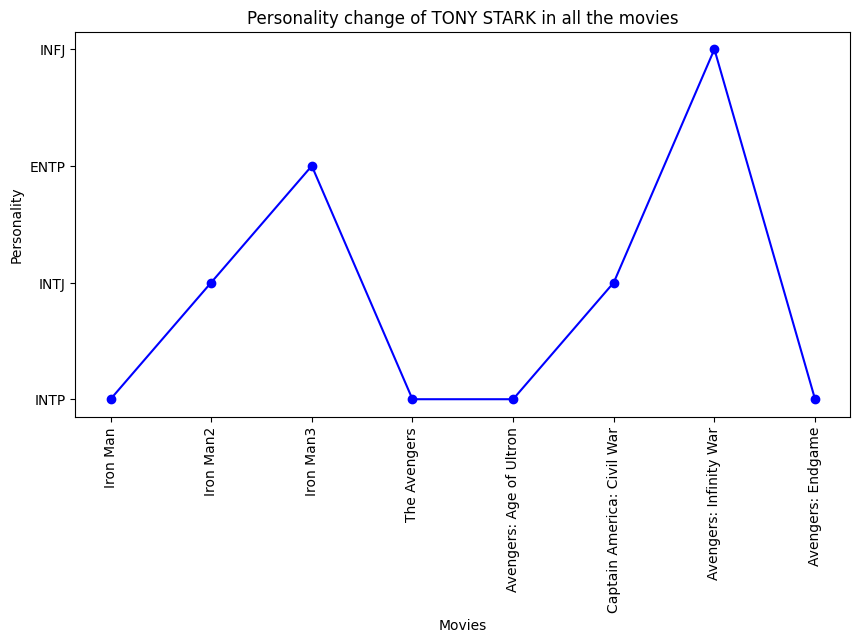

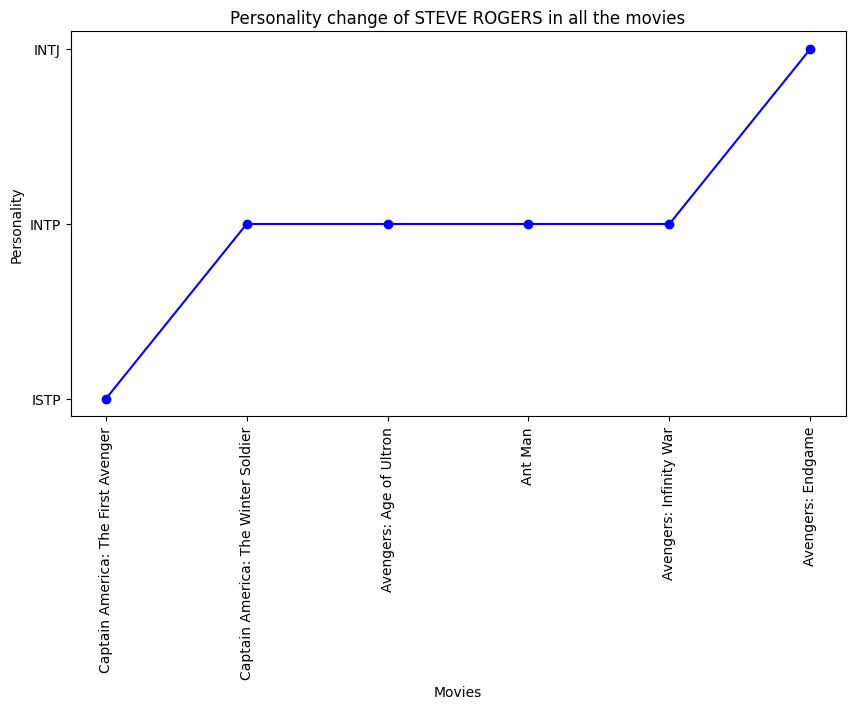

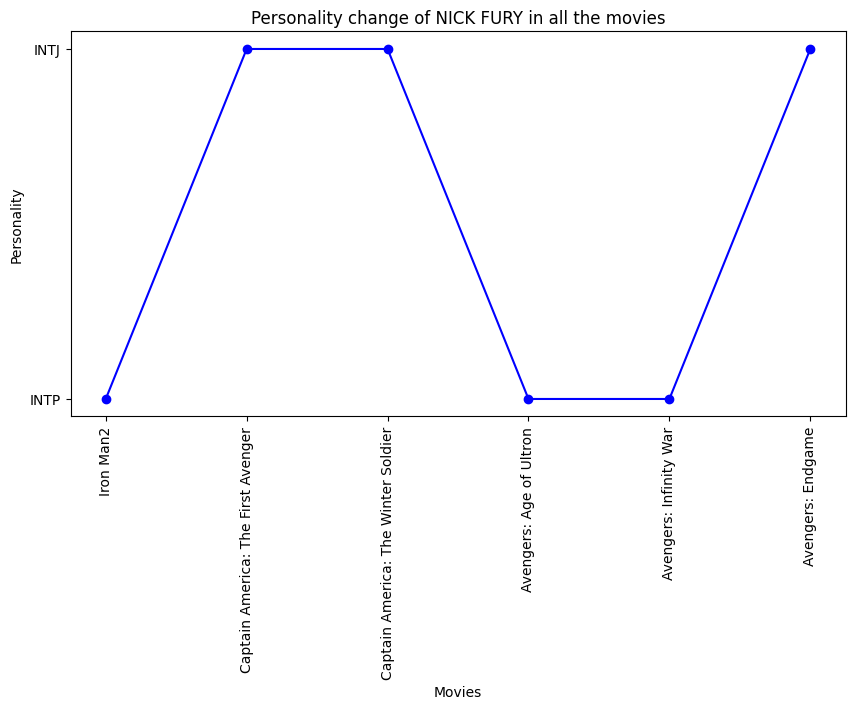

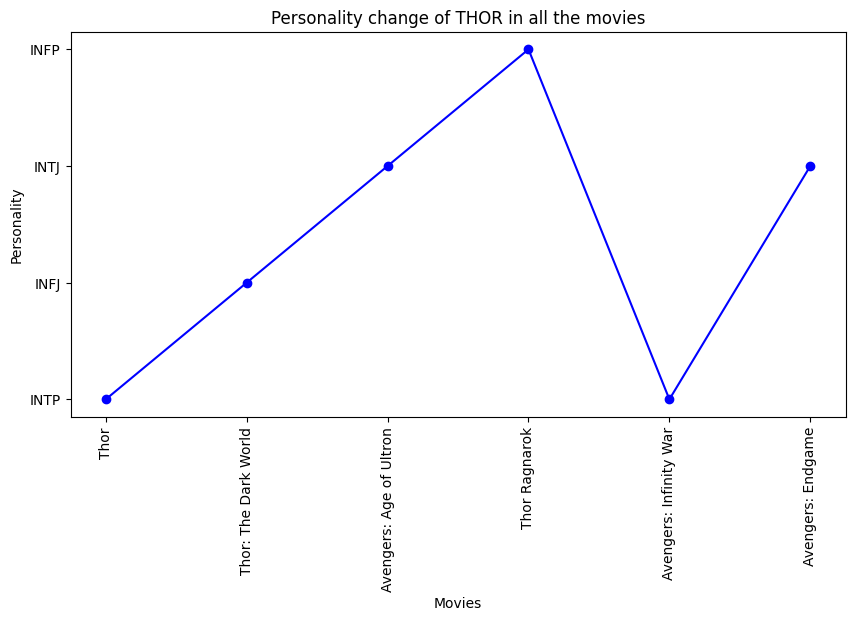

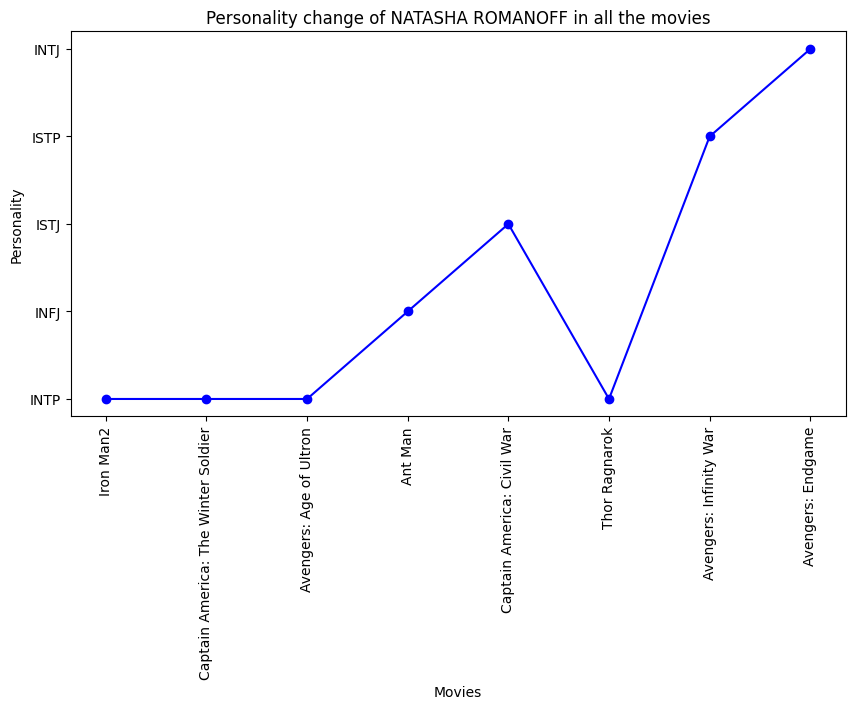

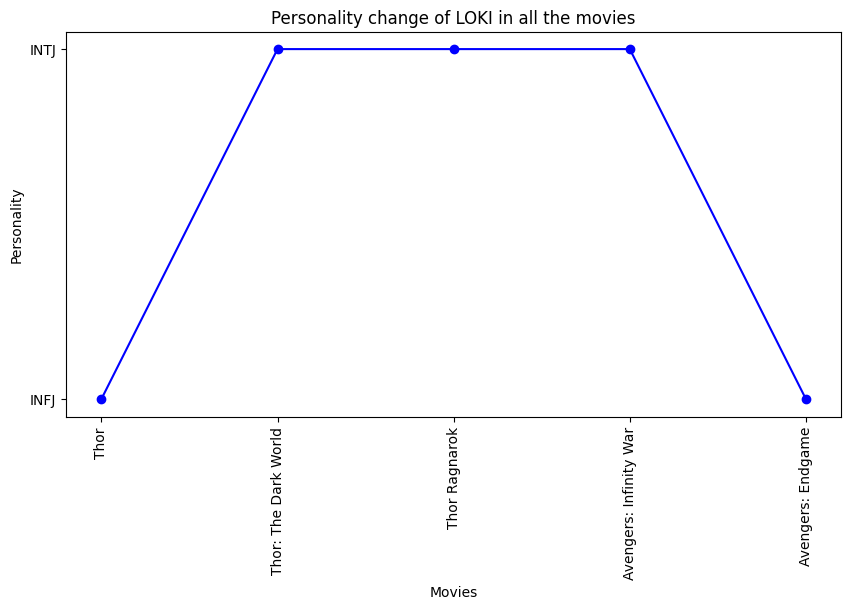

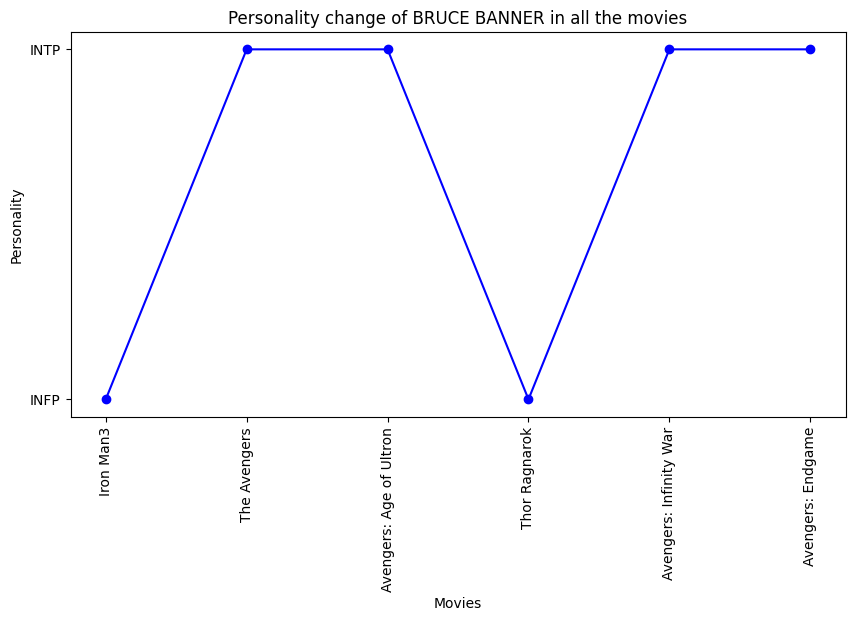

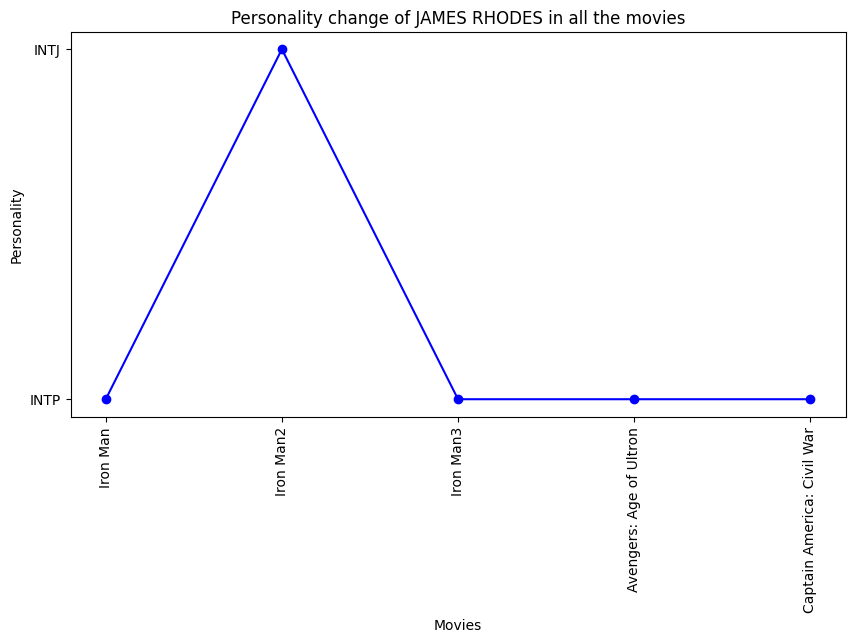

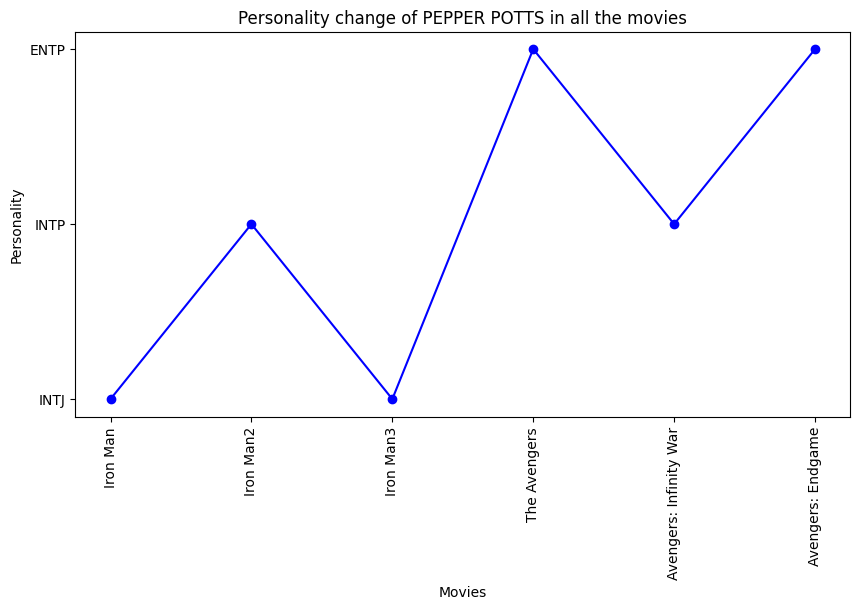

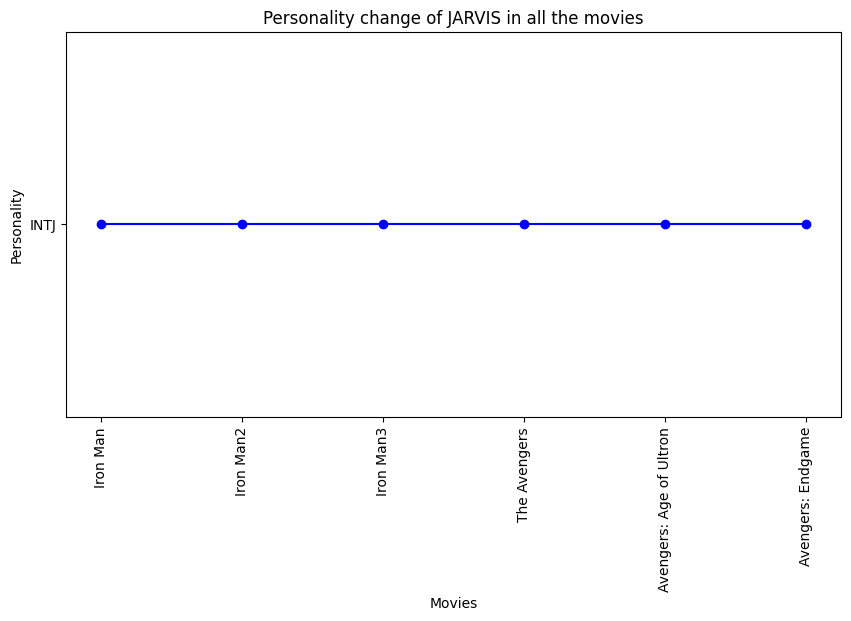

In [182]:
plot_personality('TONY STARK')
plot_personality('STEVE ROGERS')
plot_personality('NICK FURY')
plot_personality('THOR')
plot_personality('NATASHA ROMANOFF')
plot_personality('LOKI')
plot_personality('BRUCE BANNER')
plot_personality('JAMES RHODES')
plot_personality('PEPPER POTTS')
plot_personality('JARVIS')